In [1]:
import pandas as pd
import numpy as np


library_df = pd.read_csv("../Datasets/Merged_Data/merged_data.csv")

final_features = [
    "UNEMPLOYMENT_RATE", "MEDIAN_INCOME", "BACHELORS_PERCENT", "TOTCIR", "F_TOTCIR", 
    "VISITS", "F_VISITS", "REGBOR", "F_REGBOR", "GPTERMS", "F_GPTERM", "TOTSTAFF", 
    "F_TOTSTF", "HRS_OPEN", "F_HRS_OP", "TOTPRO", "F_TOTPRO", "TOTATTEN", "F_TOTATT", 
    "TOTINCM", "F_TOTINC", "TOTOPEXP", "F_TOTOPX", "POPU_UND"
    ]

# Create a copy of the dataframe
analysis_df = library_df.loc[:, final_features].copy()

print(analysis_df.columns.tolist())

['UNEMPLOYMENT_RATE', 'MEDIAN_INCOME', 'BACHELORS_PERCENT', 'TOTCIR', 'F_TOTCIR', 'VISITS', 'F_VISITS', 'REGBOR', 'F_REGBOR', 'GPTERMS', 'F_GPTERM', 'TOTSTAFF', 'F_TOTSTF', 'HRS_OPEN', 'F_HRS_OP', 'TOTPRO', 'F_TOTPRO', 'TOTATTEN', 'F_TOTATT', 'TOTINCM', 'F_TOTINC', 'TOTOPEXP', 'F_TOTOPX', 'POPU_UND']


# Data Preprocessing

In [2]:
# Step 1a: Replace the sentinel for missing income
analysis_df["MEDIAN_INCOME"] = analysis_df["MEDIAN_INCOME"].replace(-666666666.0, np.nan)

# Step 1b: Treat zeros in the other three features as missing
for col in ["BACHELORS_PERCENT", "UNEMPLOYMENT_RATE"]:
    analysis_df[col] = analysis_df[col].replace(0.0, np.nan)


In [3]:
feature_to_flag = {
    "TOTCIR": "F_TOTCIR",
    "VISITS": "F_VISITS",
    "HRS_OPEN": "F_HRS_OP",
    "GPTERMS": "F_GPTERM",
    "TOTATTEN": "F_TOTATT",
    "REGBOR": "F_REGBOR",
    "TOTPRO": "F_TOTPRO",
    "TOTSTAFF": "F_TOTSTF",
    "TOTINCM": "F_TOTINC",
    "TOTOPEXP": "F_TOTOPX"
}

drop_flags = ['U_22', 'H_22', 'L_22']

In [4]:
# Step 2: Convert 0, -1, -3 and -9 into NaN for each feature
for feat in feature_to_flag:
    if feat in analysis_df:
        analysis_df[feat] = analysis_df[feat].replace([0, -1, -3], np.nan)

analysis_df["POPU_UND"] = analysis_df["POPU_UND"].replace([0, -1, -3, -9], np.nan)



In [5]:
# Step 3: Drop rows with NaN POPU_UND values
analysis_df = analysis_df[analysis_df["POPU_UND"] != np.nan]

In [6]:
# Step 3: Null‑out values whose flag indicates suppression/unusable data
for feat, flag in feature_to_flag.items():
    if flag in analysis_df.columns:
        mask = analysis_df[flag].isin(drop_flags)
        analysis_df.loc[mask, feat] = np.nan

In [7]:
# Step 4: Create binary “_imputed” indicator columns
for feat, flag in feature_to_flag.items():
    if flag in analysis_df.columns:
        analysis_df[f"{feat}_IMPUTED"] = analysis_df[flag].str.startswith("I")

In [8]:
# Step 5: Drop the original F_* flag columns
analysis_df.drop(columns=list(feature_to_flag.values()), inplace=True)

In [ ]:
from sklearn.impute import KNNImputer

# Step 6a: List all columns to feed into the imputer:
numeric_cols = list(feature_to_flag.keys()) + ["MEDIAN_INCOME", "BACHELORS_PERCENT", "UNEMPLOYMENT_RATE"]

# Step 6b: Instantiate and apply KNNImputer
knn = KNNImputer(n_neighbors=5)
analysis_df[numeric_cols] = knn.fit_transform(analysis_df[numeric_cols])

analysis_df.dropna(subset=["POPU_UND"], inplace=True)

print(analysis_df.isna().sum())

UNEMPLOYMENT_RATE    0
MEDIAN_INCOME        0
BACHELORS_PERCENT    0
TOTCIR               0
VISITS               0
REGBOR               0
GPTERMS              0
TOTSTAFF             0
HRS_OPEN             0
TOTPRO               0
TOTATTEN             0
TOTINCM              0
TOTOPEXP             0
POPU_UND             0
TOTCIR_IMPUTED       0
VISITS_IMPUTED       0
HRS_OPEN_IMPUTED     0
GPTERMS_IMPUTED      0
TOTATTEN_IMPUTED     0
REGBOR_IMPUTED       0
TOTPRO_IMPUTED       0
TOTSTAFF_IMPUTED     0
TOTINCM_IMPUTED      0
TOTOPEXP_IMPUTED     0
dtype: int64


# Feature Engineering

In [11]:
# Per-Capita Metrics
analysis_df["CHECKOUTS_PER_CAPITA"] = analysis_df["TOTCIR"] / analysis_df["POPU_UND"]
analysis_df["ATTENDANCE_PER_CAPITA"] = analysis_df["TOTATTEN"] / analysis_df["POPU_UND"]
analysis_df["VISITS_PER_CAPITA"] = analysis_df["VISITS"] / analysis_df["POPU_UND"]


derived_feature_map = {
    "CHECKOUTS_PER_CAPITA": "TOTCIR",
    "VISITS_PER_CAPITA": "VISITS",
    "ATTENDANCE_PER_CAPITA": "TOTATTEN",
}


# Rename the *_IMPUTED columns according to the derived features
for new_col, original_col in derived_feature_map.items():
    imputed_col = f"{original_col}_IMPUTED"
    if imputed_col in analysis_df.columns:
        analysis_df.rename(columns={imputed_col: f"{new_col}_IMPUTED"}, inplace=True)

# Drop redundant features
analysis_df.drop(columns=["TOTCIR", "VISITS", "TOTATTEN"], inplace=True)

print(analysis_df.columns.tolist())
    

['UNEMPLOYMENT_RATE', 'MEDIAN_INCOME', 'BACHELORS_PERCENT', 'REGBOR', 'GPTERMS', 'TOTSTAFF', 'HRS_OPEN', 'TOTPRO', 'TOTINCM', 'TOTOPEXP', 'POPU_UND', 'CHECKOUTS_PER_CAPITA_IMPUTED', 'VISITS_PER_CAPITA_IMPUTED', 'HRS_OPEN_IMPUTED', 'GPTERMS_IMPUTED', 'ATTENDANCE_PER_CAPITA_IMPUTED', 'REGBOR_IMPUTED', 'TOTPRO_IMPUTED', 'TOTSTAFF_IMPUTED', 'TOTINCM_IMPUTED', 'TOTOPEXP_IMPUTED', 'CHECKOUTS_PER_CAPITA', 'ATTENDANCE_PER_CAPITA', 'VISITS_PER_CAPITA']


# Exploratory Data Analysis (EDA)

In [12]:
# Data shape and types
print("Shape:", analysis_df.shape)
print("\nDtypes:\n", analysis_df.dtypes)

Shape: (9160, 24)

Dtypes:
 UNEMPLOYMENT_RATE                float64
MEDIAN_INCOME                    float64
BACHELORS_PERCENT                float64
REGBOR                           float64
GPTERMS                          float64
TOTSTAFF                         float64
HRS_OPEN                         float64
TOTPRO                           float64
TOTINCM                          float64
TOTOPEXP                         float64
POPU_UND                         float64
CHECKOUTS_PER_CAPITA_IMPUTED        bool
VISITS_PER_CAPITA_IMPUTED           bool
HRS_OPEN_IMPUTED                    bool
GPTERMS_IMPUTED                     bool
ATTENDANCE_PER_CAPITA_IMPUTED       bool
REGBOR_IMPUTED                      bool
TOTPRO_IMPUTED                      bool
TOTSTAFF_IMPUTED                    bool
TOTINCM_IMPUTED                     bool
TOTOPEXP_IMPUTED                    bool
CHECKOUTS_PER_CAPITA             float64
ATTENDANCE_PER_CAPITA            float64
VISITS_PER_CAPITA            

In [13]:
# Head and descriptive stats
display(analysis_df.head())
display(analysis_df.describe().T)

,UNEMPLOYMENT_RATE,MEDIAN_INCOME,BACHELORS_PERCENT,REGBOR,GPTERMS,TOTSTAFF,HRS_OPEN,TOTPRO,TOTINCM,TOTOPEXP,...,GPTERMS_IMPUTED,ATTENDANCE_PER_CAPITA_IMPUTED,REGBOR_IMPUTED,TOTPRO_IMPUTED,TOTSTAFF_IMPUTED,TOTINCM_IMPUTED,TOTOPEXP_IMPUTED,CHECKOUTS_PER_CAPITA,ATTENDANCE_PER_CAPITA,VISITS_PER_CAPITA
0,108.0,58018.0,279.0,1950.0,5.0,0.68,1404.0,150.0,71874.0,66006.0,...,False,False,False,False,False,False,False,4.143130,0.428435,2.446088
1,416.0,72958.0,1832.0,123846.0,161.0,60.00,7596.0,758.0,9357471.0,9181224.0,...,False,False,False,False,False,False,False,3.037981,0.037071,0.902910
2,3.0,111250.0,6.0,138.0,2.2,0.30,420.0,54.6,13885.0,15337.0,...,False,False,True,False,True,False,True,4.352273,3.419318,2.392045
3,363.0,94313.0,376.0,2062.0,8.0,2.50,2040.0,80.0,138115.0,241204.0,...,False,False,False,False,False,False,False,1.584882,0.742576,2.035414
4,566.0,87247.0,1629.0,2867.0,7.0,6.00,2356.0,249.0,417502.0,394686.0,...,False,False,False,False,False,False,False,2.863800,0.870285,2.700359


,count,mean,std,min,25%,50%,75%,max
UNEMPLOYMENT_RATE,9160.0,3.310280e+02,4.483970e+02,1.000000,42.000000,148.500000,4.482500e+02,3.987000e+03
MEDIAN_INCOME,9160.0,7.453510e+04,3.039973e+04,10850.000000,55504.250000,67253.000000,8.531075e+04,2.500010e+05
BACHELORS_PERCENT,9160.0,1.757641e+03,2.413489e+03,1.000000,230.000000,720.500000,2.304000e+03,2.154900e+04
REGBOR,9160.0,1.932996e+04,8.590114e+04,1.000000,994.000000,3082.000000,1.003575e+04,2.863691e+06
GPTERMS,9160.0,3.089347e+01,1.139388e+02,1.000000,5.000000,9.000000,2.100000e+01,3.790000e+03
TOTSTAFF,9160.0,1.620403e+01,5.674658e+01,0.030000,1.500000,4.000000,1.130250e+01,2.197960e+03
HRS_OPEN,9160.0,3.970446e+03,8.416883e+03,12.000000,1641.000000,2270.000000,3.016000e+03,2.122850e+05
TOTPRO,9160.0,3.793521e+02,1.113726e+03,1.000000,55.000000,154.000000,3.710000e+02,6.359800e+04
TOTINCM,9160.0,1.867498e+06,8.307901e+06,236.000000,89928.000000,290712.000000,1.037359e+06,3.517798e+08
TOTOPEXP,9160.0,1.697170e+06,7.647920e+06,378.000000,85297.750000,269010.000000,9.303082e+05,3.319634e+08


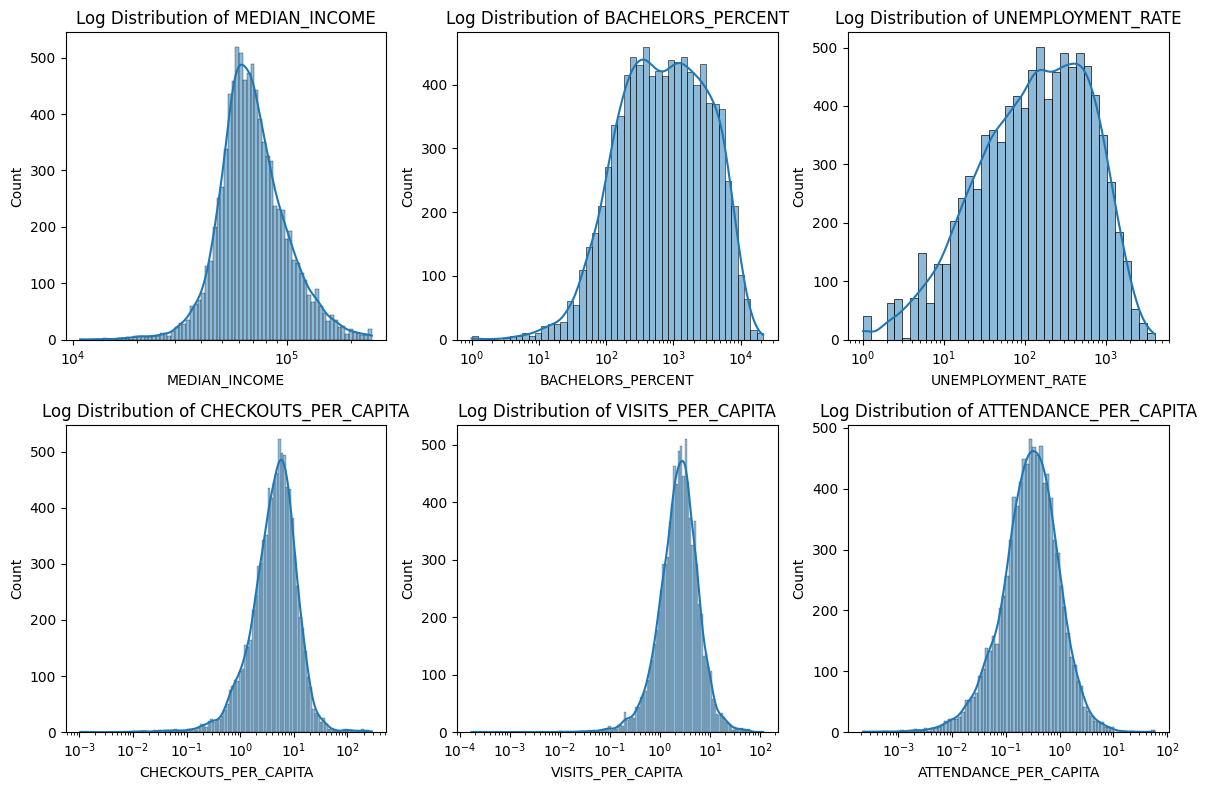

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

features_to_plot = [
    "MEDIAN_INCOME", "BACHELORS_PERCENT", "UNEMPLOYMENT_RATE",
    "CHECKOUTS_PER_CAPITA", "VISITS_PER_CAPITA", 
    "ATTENDANCE_PER_CAPITA"
]

plt.figure(figsize=(12, 8))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.histplot(analysis_df[feature], kde=True, log_scale=True)
    plt.title(f"Log Distribution of {feature}")
plt.tight_layout()
plt.show()

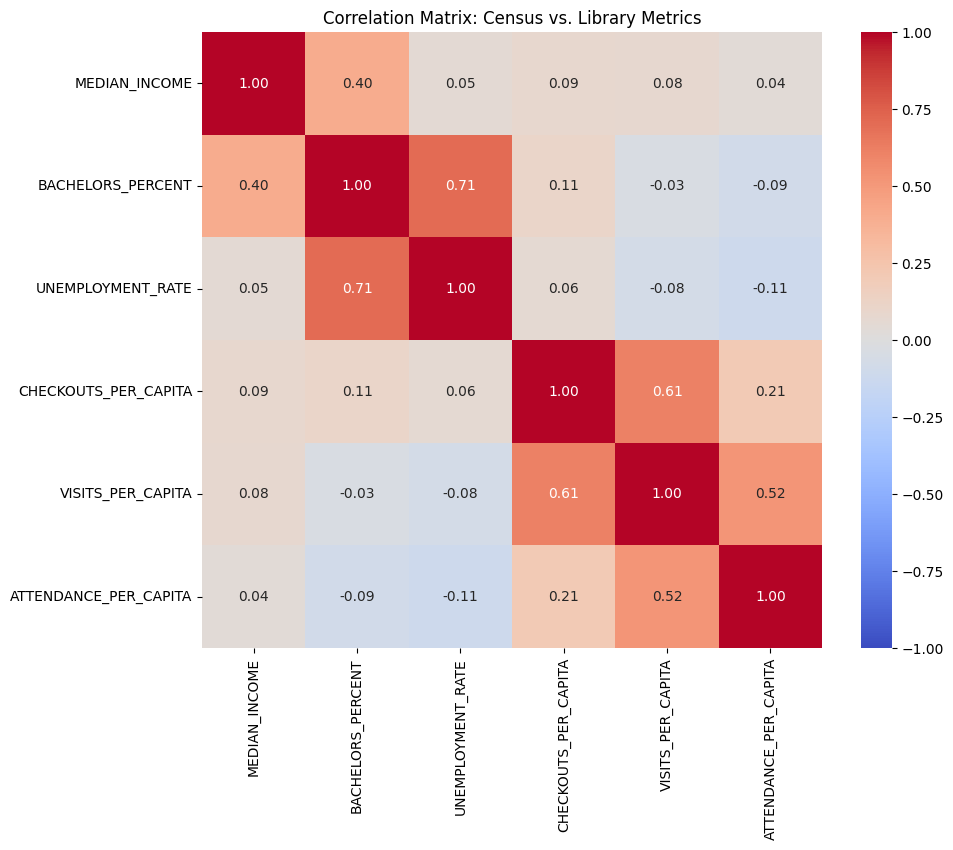

In [15]:
# Correlation matrix (focus on census vs. library metrics)
correlation_features = [
    "MEDIAN_INCOME", "BACHELORS_PERCENT", "UNEMPLOYMENT_RATE",
    "CHECKOUTS_PER_CAPITA", "VISITS_PER_CAPITA", "ATTENDANCE_PER_CAPITA"
]

plt.figure(figsize=(10, 8))
sns.heatmap(
    analysis_df[correlation_features].corr(),
    annot=True, cmap="coolwarm", vmin=-1, vmax=1, fmt=".2f"
)
plt.title("Correlation Matrix: Census vs. Library Metrics")
plt.show()

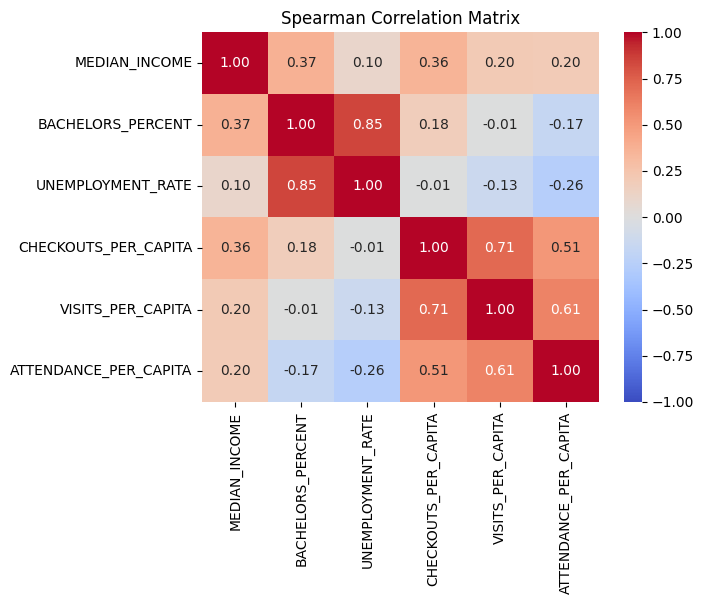

In [16]:
# Compute Spearman correlation
spearman_corr = analysis_df[correlation_features].corr(method="spearman")

# Visualize
sns.heatmap(
    spearman_corr, 
    annot=True, cmap="coolwarm", vmin=-1, vmax=1,
    annot_kws={"size": 10}, fmt=".2f"
)
plt.title("Spearman Correlation Matrix")
plt.show()

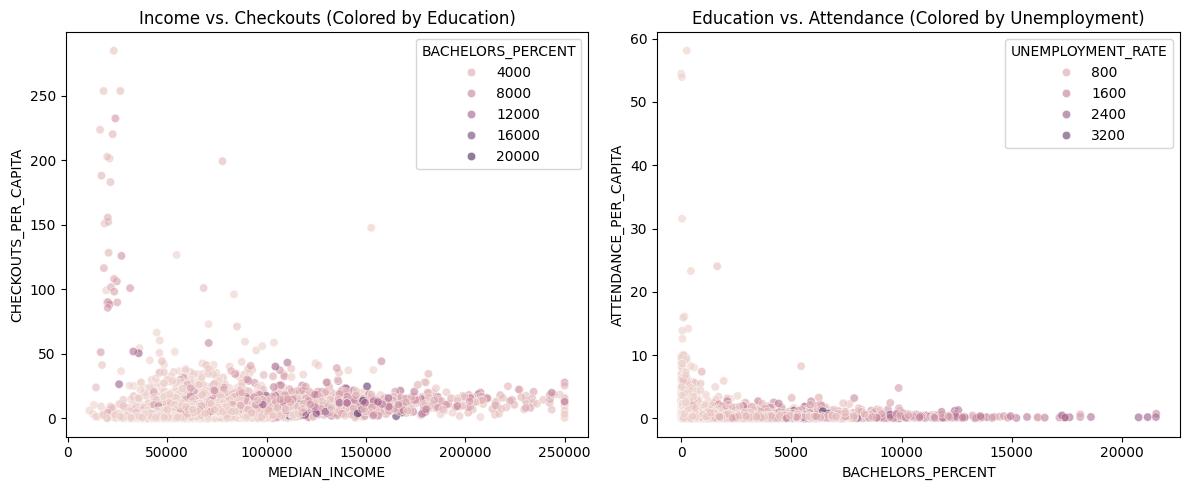

In [17]:
# Scatter plots: Income/Education vs. Checkouts/Attendance
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(
    x="MEDIAN_INCOME", y="CHECKOUTS_PER_CAPITA",
    hue="BACHELORS_PERCENT", data=analysis_df, alpha=0.6
)
plt.title("Income vs. Checkouts (Colored by Education)")

plt.subplot(1, 2, 2)
sns.scatterplot(
    x="BACHELORS_PERCENT", y="ATTENDANCE_PER_CAPITA",
    hue="UNEMPLOYMENT_RATE", data=analysis_df, alpha=0.6
)
plt.title("Education vs. Attendance (Colored by Unemployment)")
plt.tight_layout()
plt.show()

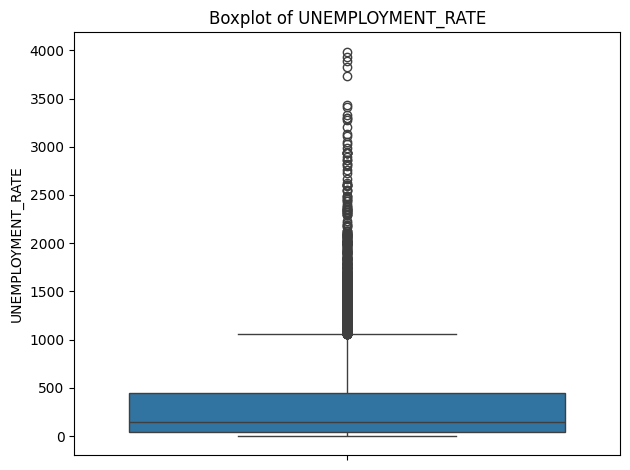

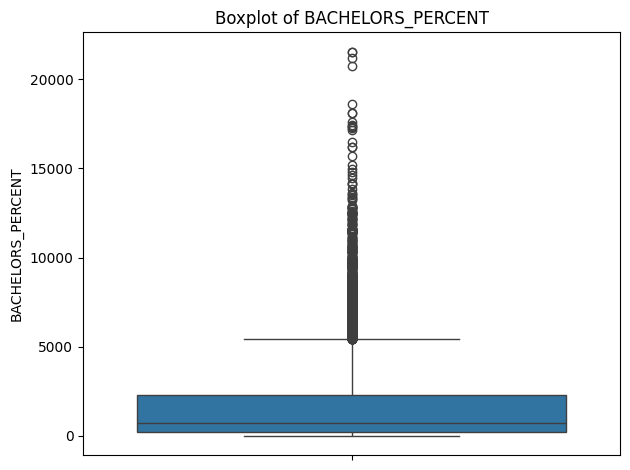

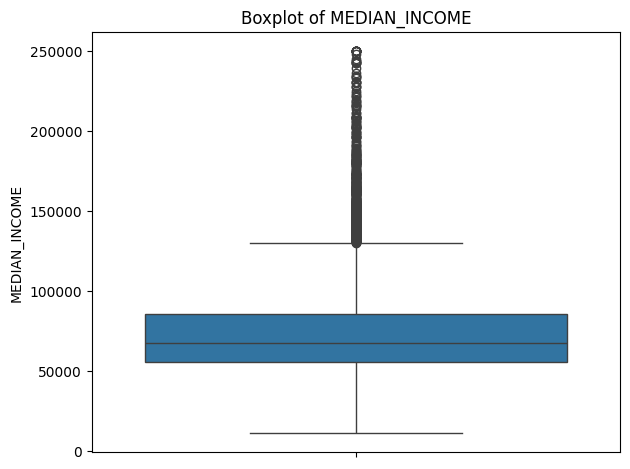

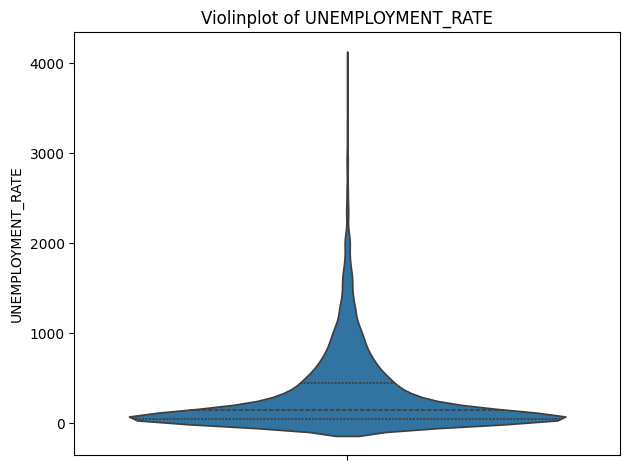

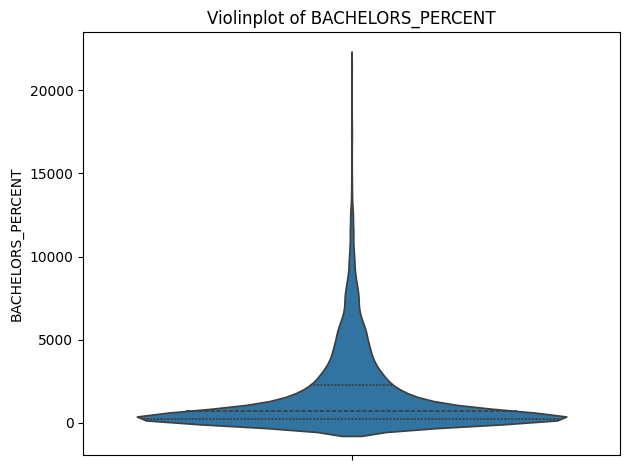

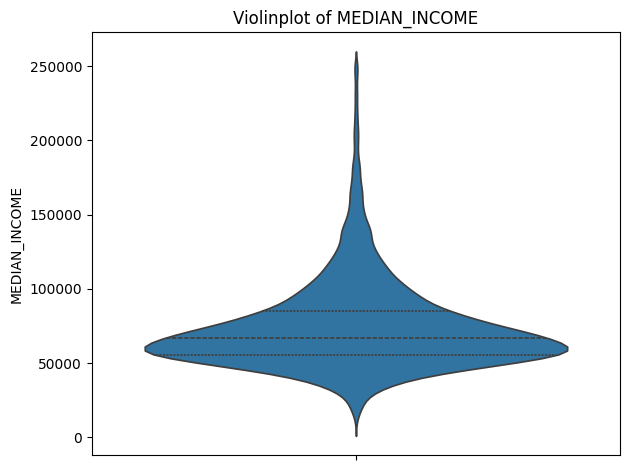

In [18]:

cols = [
    "UNEMPLOYMENT_RATE",
    "BACHELORS_PERCENT",
    "MEDIAN_INCOME"
]

# Boxplots
for col in cols:
    plt.figure()
    sns.boxplot(y=analysis_df[col])
    plt.title(f"Boxplot of {col}")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

# Violinplots
for col in cols:
    plt.figure()
    sns.violinplot(y=analysis_df[col], inner="quartile")
    plt.title(f"Violinplot of {col}")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

# Hypothesis Tests

**Hypothesis Test 1: Median Income and Library Visits**    
-H₀: Median household income and visits per capita are uncorrelated.  
-H₁: They are positively correlated.

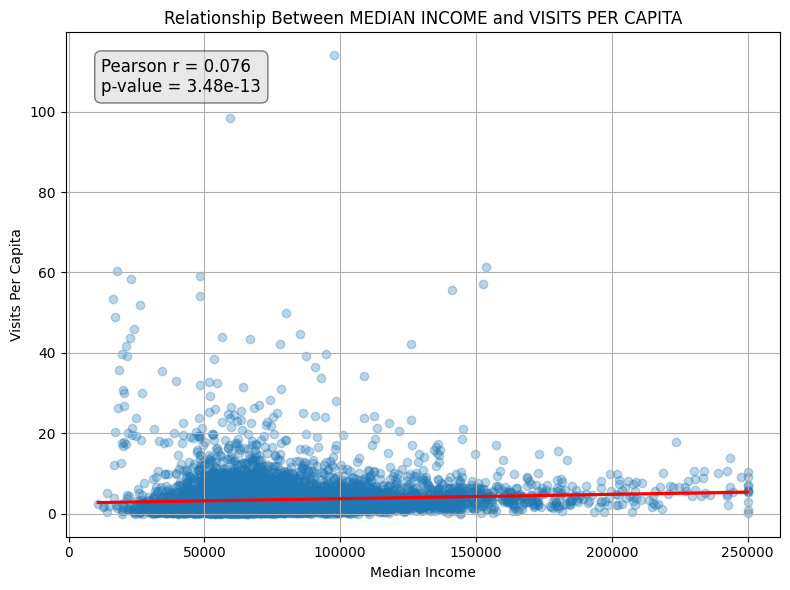

In [ ]:
from scipy.stats import pearsonr

# Choose the variables
x_var = "MEDIAN_INCOME"
y_var = "VISITS_PER_CAPITA"

# Calculate Pearson correlation
r, p = pearsonr(analysis_df[x_var], analysis_df[y_var])

# Create the plot
plt.figure(figsize=(8, 6))
sns.regplot(
    data=analysis_df,
    x=x_var,
    y=y_var,
    scatter_kws={'alpha': 0.3},
    line_kws={'color': 'red'}
)

# Annotate correlation and p-value
plt.text(
    0.05, 0.95,
    f"Pearson r = {r:.3f}\np-value = {p:.2e}",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top',
    bbox=dict(boxstyle='round,pad=0.4', facecolor='lightgray', alpha=0.5)
)

plt.title(f"Relationship Between {x_var.replace('_', ' ')} and {y_var.replace('_', ' ')}")
plt.xlabel(x_var.replace("_", " ").title())
plt.ylabel(y_var.replace("_", " ").title())
plt.grid(True)
plt.tight_layout()
plt.show()

Since p-value ≪ 0.05, we reject the null hypothesis: There is statistical evidence of a non-zero association, but since r= 0.076, this result is not practically meaningful, i.e. income only very slightly predicts library visits per capita.


**Hypothesis Test 2: One-Way ANOVA**  
*Question: Do low / medium / high income ZIPs differ in mean visits per capita?*      
-H₀: All three group means of VISITS_PER_CAPITA are equal  
-H₁: At least one group mean differs

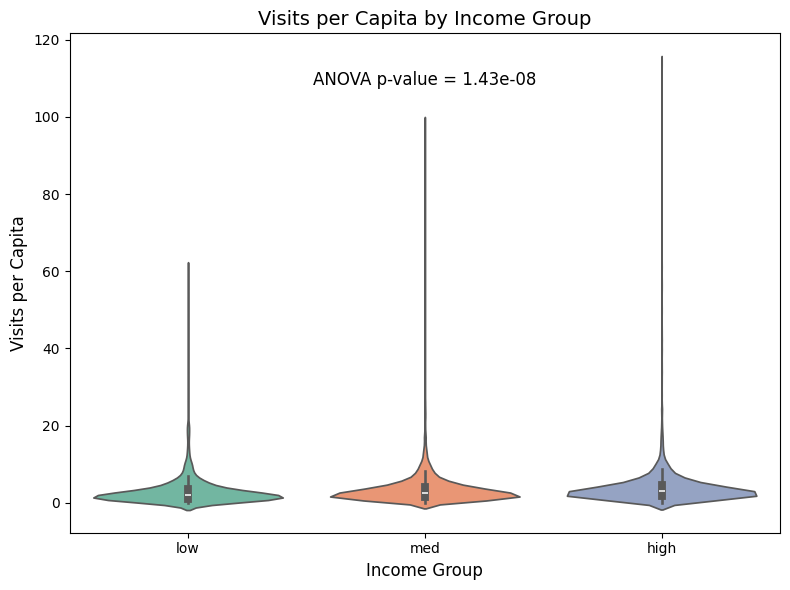

In [ ]:
from scipy.stats import f_oneway

# Bin income into tertiles
df = analysis_df.copy()
df["INCOME_GROUP"] = pd.qcut(df["MEDIAN_INCOME"], 3, labels=["low","med","high"])
groups = [g.dropna() for _,g in df.groupby("INCOME_GROUP", observed=True)["VISITS_PER_CAPITA"]]
stat, p = f_oneway(*groups)

# Create the violin plot
plt.figure(figsize=(8, 6))
sns.violinplot(
    data=df,
    x="INCOME_GROUP",
    y="VISITS_PER_CAPITA",
    inner="box",
    palette="Set2",
    hue="INCOME_GROUP",
    legend=False
)

# Annotate p-value on plot
plt.text(
    1.0, df["VISITS_PER_CAPITA"].max() * 0.95,  
    f"ANOVA p-value = {p:.2e}",
    ha="center", fontsize=12, color="black"
)

plt.title("Visits per Capita by Income Group", fontsize=14)
plt.xlabel("Income Group", fontsize=12)
plt.ylabel("Visits per Capita", fontsize=12)
plt.tight_layout()
plt.show()

Since p-value < 0.05, we reject the null hypothesis. There is a statistically significant difference in VISITS_PER_CAPITA across income groups (low/med/high).

**Hypothesis Test 3: Chi-Square Test of Independence**  
*Question: Is there an association between ZIP code income level (Low / Medium / High) and library program offerings?*      
-H₀: Income group and program offering level are independent.  
-H₁: Income group and program offering level are associated.

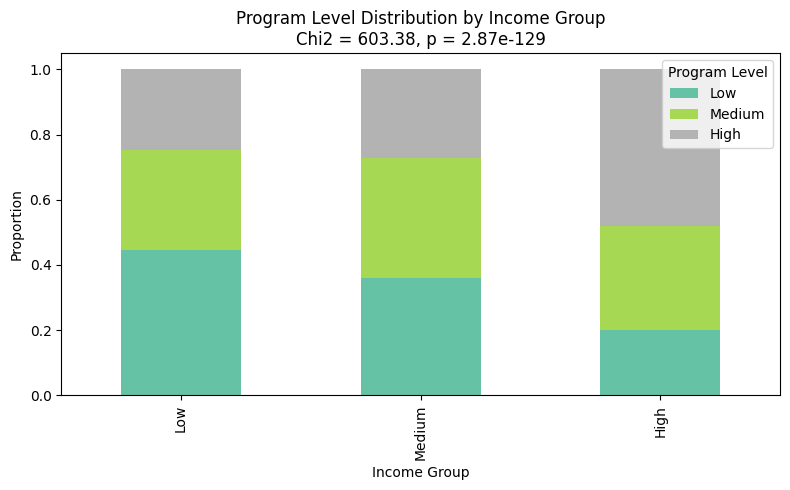

In [ ]:
from scipy.stats import chi2_contingency

# 1. Filter out rows where TOTPRO was imputed
filtered_df = analysis_df[analysis_df["TOTPRO_IMPUTED"] == False].copy()

# 2. Define income group buckets (if not already defined)
filtered_df["INCOME_GROUP"] = pd.qcut(filtered_df["MEDIAN_INCOME"], q=3, labels=["Low", "Medium", "High"])

# 3. Create PROGRAM_LEVEL based on tertiles of TOTPRO
filtered_df["PROGRAM_LEVEL"] = pd.qcut(filtered_df["TOTPRO"], q=3, labels=["Low", "Medium", "High"])

# 4. Create contingency table
contingency = pd.crosstab(filtered_df["INCOME_GROUP"], filtered_df["PROGRAM_LEVEL"])

# 5. Run Chi-Square Test of Independence
chi2, p, dof, expected = chi2_contingency(contingency)

contingency_norm = contingency.div(contingency.sum(axis=1), axis=0)

contingency_norm.plot(kind="bar", stacked=True, colormap="Set2", figsize=(8, 5))

plt.title(f"Program Level Distribution by Income Group\nChi2 = {chi2:.2f}, p = {p:.2e}")
plt.ylabel("Proportion")
plt.xlabel("Income Group")
plt.legend(title="Program Level")
plt.tight_layout()
plt.show()

Since p_value ≪ 0.05, and even ≪ 0.001, we reject the null hypothesis. Library program levels tend to differ substantially depending on whether a ZIP code is low-, medium-, or high-income.

**Hypothesis Test 4: Two-Sample T-Test**  
*Question: Do libraries in high-income ZIP codes have significantly more library staff (TOTSTAFF) than those in low-income ZIP codes?*        
-H₀: There is no significant difference in the mean number of library staff between high-income and low-income ZIP codes.  
-H₁: There is a significant difference in the mean number of library staff between high-income and low-income ZIP codes.

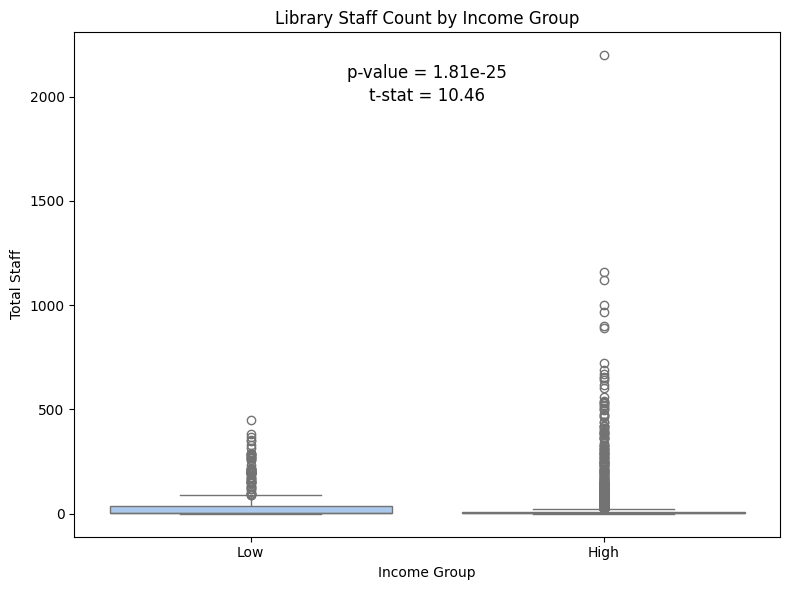

In [60]:
from scipy.stats import ttest_ind

temp_df = analysis_df.copy()

temp_df['Income_Group'] = pd.cut(temp_df['MEDIAN_INCOME'], bins=[0, 40000, np.inf], labels=['Low', 'High'])

temp_df_clean = temp_df.dropna(subset=['TOTSTAFF', 'MEDIAN_INCOME'])


low_income = temp_df_clean[temp_df_clean['Income_Group'] == 'Low']['TOTSTAFF']
high_income = temp_df_clean[temp_df_clean['Income_Group'] == 'High']['TOTSTAFF']

t_stat, p_value = ttest_ind(low_income, high_income)


plt.figure(figsize=(8, 6))
sns.boxplot(data=temp_df_clean[temp_df_clean["Income_Group"].isin(["Low", "High"])],
            x="Income_Group", y='TOTSTAFF', palette="pastel", hue="Income_Group", legend=False)

plt.title("Library Staff Count by Income Group")
plt.xlabel("Income Group")
plt.ylabel("Total Staff")

# Annotate p-value on the plot
plt.text(0.5, temp_df_clean["TOTSTAFF"].max() * 0.95,
         f'p-value = {p_value:.2e}',
         ha='center', fontsize=12, color='black')

plt.text(0.5, temp_df_clean['TOTSTAFF'].max() * 0.90,
        f't-stat = {t_stat:.2f}', ha='center',
        fontsize=12, color='black')

plt.tight_layout()
plt.show()

Since p_value ≪ 0.05, we reject the null hypothesis. The difference in the mean number of library staff between two income groups is significant, although looking at the box plot comparison, this result is not practically meaningful.